# 1nd and 2nd model

In [40]:
# !pip3 install pandas tensorflow
# !pip3 uninstall tensorflow -y

!pip3 install pandas tensorflow-metal tensorflow-macos

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [31]:
import pandas as pd

# Loading the dataset to take a peek at its structure and content
file_path_emotions = '../data/emotions_train_ready.csv'

# Reading the dataset
emotions_data = pd.read_csv(file_path_emotions)
emotions_data.head()

,Unnamed: 0,text,label
0,0,"Yeah, but nobody takes McD's hamburgers seriou...",1
1,1,"Clear your notifications, good [NAME]!!",1
2,2,Idaho lot rather we stop with these amas.,1
3,3,Are you in enough of a hurry to get in anyway?...,3
4,4,He's hot,6


### SVC Model

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Preprocessing and vectorizing the text data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(emotions_data['text'])
y = emotions_data['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the SVM model
svm_model = SVC(kernel='linear', verbose=True)
svm_model.fit(X_train, y_train)

# Predicting and evaluating the model on the test set
y_pred = svm_model.predict(X_test)
report = classification_report(y_test, y_pred)

report


[LibSVM]..................*............*
optimization finished, #iter = 30287
obj = -4101.926029, rho = 0.658006
nSV = 8838, nBSV = 3924
.......*.....*
optimization finished, #iter = 12402
obj = -1749.927301, rho = -0.269258
nSV = 4444, nBSV = 1553
...........

In [5]:
## Report for SVC
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()

print(report_df)

NameError: name 'classification_report' is not defined

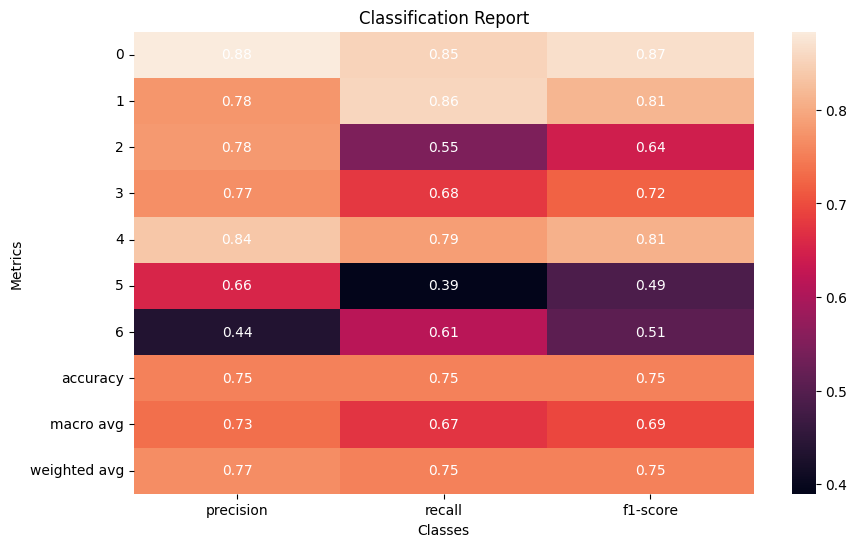

In [ ]:
# Generate a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

report_df = pd.DataFrame(report).iloc[:-1, :].T  # exclude the last row for averages

plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(report_df, annot=False, fmt=".2f")

# Manually annotate with the exact values
for y, row in enumerate(report_df.values):
    for x, val in enumerate(row):
        plt.text(x + 0.5, y + 0.5, '{:0.2f}'.format(val), 
                 ha='center', va='center', 
                 color='white')

# labels and title for clarity
plt.yticks(rotation=0)
plt.title('Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')

plt.show()

------------

### Trying out a neural net for this task - Simple RNN

In [65]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def tokenize_and_split(input_data):
    data_df = input_data.copy()
    
    tokenizer = Tokenizer(num_words=10000)  # Adjust num_words as needed
    tokenizer.fit_on_texts(data_df['text'])
    sequences = tokenizer.texts_to_sequences(data_df['text'])

    # Pad sequences
    X = pad_sequences(sequences, maxlen=80)  # Adjust maxlen as needed

    # One-hot encode labels
    y = to_categorical(data_df['label'])

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = tokenize_and_split(emotions_data)

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

most_common_tokens = 10002
vocab_size = most_common_tokens

embedding_dim = 256
rnn_units = 128 
num_classes = 7  


def create_rnn_model(vocab_size, embedding_dim, rnn_units, num_classes):
    # Build the model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=80),
        SimpleRNN(rnn_units),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = create_rnn_model(vocab_size, embedding_dim, rnn_units, num_classes)

In [50]:
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)


Training data shape: (359382, 80) (359382, 7)
Validation data shape: (119794, 80) (119794, 7)
Test data shape: (119795, 80) (119795, 7)


In [51]:
X_train, y_train, X_train.shape, y_train.shape 

(array([[   0,    0,    0, ...,   12,    3,  508],
        [   0,    0,    0, ...,   90,    8,   11],
        [   0,    0,    0, ...,  128,   30,  412],
        ...,
        [   0,    0,    0, ...,   22,    2,  856],
        [   0,    0,    0, ...,    3, 5057, 7415],
        [   0,    0,    0, ...,  245,  211,  565]], dtype=int32),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 (359382, 80),
 (359382, 7))

In [52]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [53]:
num_epochs = 5

history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5


11231/11231 [==============================] - 368s 33ms/step - loss: 1.0443 - accuracy: 0.6378 - val_loss: 0.8492 - val_accuracy: 0.7059
Epoch 2/5
11231/11231 [==============================] - 355s 32ms/step - loss: 0.8645 - accuracy: 0.7060 - val_loss: 0.9201 - val_accuracy: 0.6754
Epoch 3/5
11231/11231 [==============================] - 363s 32ms/step - loss: 0.8306 - accuracy: 0.7063 - val_loss: 0.7657 - val_accuracy: 0.7307
Epoch 4/5
11231/11231 [==============================] - 392s 35ms/step - loss: 0.7083 - accuracy: 0.7479 - val_loss: 0.9542 - val_accuracy: 0.6637
Epoch 5/5
11231/11231 [==============================] - 373s 33ms/step - loss: 0.6187 - accuracy: 0.7742 - val_loss: 0.5867 - val_accuracy: 0.7770


In [54]:
num_epochs = 10

history_continued = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
11231/11231 [==============================] - 383s 34ms/step - loss: 0.5810 - accuracy: 0.7844 - val_loss: 0.6019 - val_accuracy: 0.7806
Epoch 2/10
11231/11231 [==============================] - 382s 34ms/step - loss: 0.6618 - accuracy: 0.7691 - val_loss: 0.6087 - val_accuracy: 0.7721
Epoch 3/10
11231/11231 [==============================] - 389s 35ms/step - loss: 0.5731 - accuracy: 0.7878 - val_loss: 0.7801 - val_accuracy: 0.7440
Epoch 4/10
11231/11231 [==============================] - 373s 33ms/step - loss: 0.5505 - accuracy: 0.7928 - val_loss: 0.5761 - val_accuracy: 0.7816
Epoch 5/10
11231/11231 [==============================] - 366s 33ms/step - loss: 0.5730 - accuracy: 0.7881 - val_loss: 0.6685 - val_accuracy: 0.7512
Epoch 6/10
11231/11231 [==============================] - 382s 34ms/step - loss: 0.6663 - accuracy: 0.7636 - val_loss: 0.7214 - val_accuracy: 0.7479
Epoch 7/10
11231/11231 [==============================] - 377s 34ms/step - loss: 0.6357 - accuracy: 0.7698

In [55]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


3744/3744 [==============================] - 32s 9ms/step - loss: 0.6337 - accuracy: 0.7587
Test Accuracy: 0.758704423904419


In [56]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

3744/3744 [==============================] - 33s 9ms/step


In [57]:
from sklearn.metrics import classification_report

report = classification_report(y_true_classes, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     26613
           1       0.85      0.82      0.83     40018
           2       0.72      0.59      0.65      8978
           3       0.69      0.74      0.71     17162
           4       0.86      0.79      0.83     10097
           5       0.47      0.44      0.45      5908
           6       0.39      0.54      0.45     11019

    accuracy                           0.76    119795
   macro avg       0.70      0.69      0.69    119795
weighted avg       0.77      0.76      0.76    119795



label
1    199014
0    132946
3     85314
6     55298
4     50753
2     45844
5     29802
Name: count, dtype: int64
label
1    33.225983
0    22.195732
3    14.243427
6     9.232166
4     8.473365
2     7.653793
5     4.975533
Name: count, dtype: float64


/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


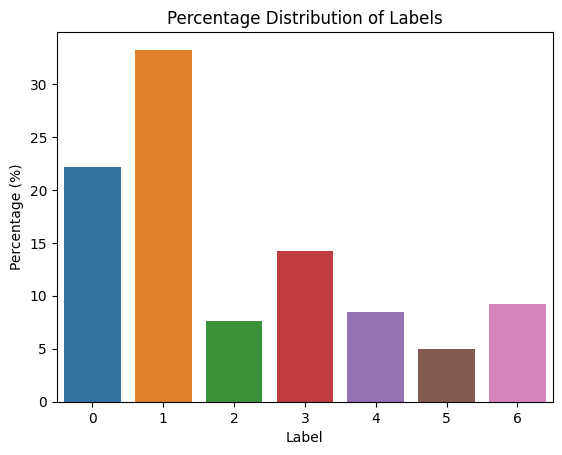

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

data = emotions_data

label_counts = data['label'].value_counts()
print(label_counts)

total_count = len(data)
label_percentages = (label_counts / total_count) * 100
print(label_percentages)

sns.barplot(x=label_percentages.index, y=label_percentages.values)
plt.title('Percentage Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.show()

In [63]:
import pandas as pd
from sklearn.utils import resample

# Desired size for each class - set this to the size of the smallest/largest class or a specific number
desired_size = data['label'].value_counts().min()  # For undersampling to the size of the smallest class
# desired_size = data['label'].value_counts().max()  # For oversampling to the size of the largest class

# Resample each class
resampled_data = pd.DataFrame()
for label in data['label'].unique():
    class_data = data[data['label'] == label]
    resampled_class_data = resample(class_data,
                                    replace=class_data.shape[0] < desired_size,  # Oversample if class size is smaller
                                    n_samples=desired_size,
                                    random_state=42)
    resampled_data = pd.concat([resampled_data, resampled_class_data])

# Shuffle the resampled data
resampled_data = resampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

X_train, X_val, X_test, y_train, y_val, y_test = tokenize_and_split(resampled_data)


label
1    29802
2    29802
3    29802
0    29802
4    29802
5    29802
6    29802
Name: count, dtype: int64
label
1    14.285714
2    14.285714
3    14.285714
0    14.285714
4    14.285714
5    14.285714
6    14.285714
Name: count, dtype: float64


/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaa/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


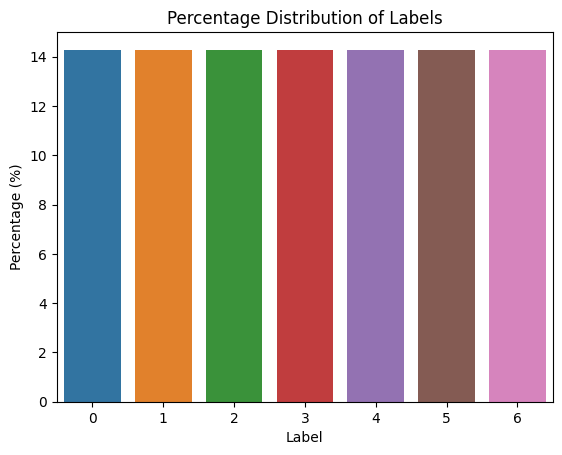

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

data = resampled_data

label_counts = data['label'].value_counts()
print(label_counts)

total_count = len(data)
label_percentages = (label_counts / total_count) * 100
print(label_percentages)

sns.barplot(x=label_percentages.index, y=label_percentages.values)
plt.title('Percentage Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Percentage (%)')
plt.show()

In [73]:
model = create_rnn_model(vocab_size, embedding_dim, rnn_units, num_classes)

In [74]:
num_epochs = 5

history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
3912/3912 [==============================] - 132s 34ms/step - loss: 1.3299 - accuracy: 0.5118 - val_loss: 1.3953 - val_accuracy: 0.5470
Epoch 2/5
3912/3912 [==============================] - 130s 33ms/step - loss: 1.1586 - accuracy: 0.5884 - val_loss: 0.9561 - val_accuracy: 0.6709
Epoch 3/5
3912/3912 [==============================] - ETA: 0s - loss: 1.1393 - accuracy: 0.5931